<a href="https://colab.research.google.com/github/rsonthal/Under-Parameterized-Double-Descent/blob/main/Shift_Alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.set_default_device("cuda")

# Input noise

In [ ]:
def shift_spectrum(X,mu):
  p, n = X.shape
  U, S, Vh = torch.linalg.svd(X, full_matrices=False)
  S_new = (S.square() + mu ** 2).sqrt()
  return U @ torch.diag(S**2/S) @ Vh

def make_noise(n, p, mu):
  return skew_eigenvectors(torch.randn(p,n)/np.sqrt(p),V)

def make_noise_ridge(n,p,mu):
  R = mu * torch.eye(p)
  A = torch.randn(p,n)/np.sqrt(p)
  A_bigger = torch.randn(n+p, n+p)
  Q = torch.linalg.svd(A_bigger)[0]

  A_hat = torch.cat((A, R), dim = 1)

  U, S, Vh = torch.linalg.svd(A_hat)
  # S = (S.square() - mu **2).abs().sqrt()
  # Vh_new = Vh @ Q

  return U @ torch.diag(S) @ Vh[:p,:]

def make_noise_ridge_rot(n,p,mu):
  R = mu * torch.eye(p)
  A = torch.randn(p,n)/np.sqrt(p)
  A_bigger = torch.randn(n+p, 1)
  Q = torch.linalg.svd(A_bigger)[0]

  A_hat = torch.cat((A, R), dim = 1)

  U, S, Vh = torch.linalg.svd(A_hat)
  # S = (S.square() - mu **2).abs().sqrt()
  # Vh_new = Vh @ Q

  return U @ torch.diag(S) @  Q[:p,:]

def skew_eigenvectors(X,V):
  U, S, Vh = torch.linalg.svd(X, full_matrices=False)

  return V[:,:S.shape[0]] @ torch.diag(S) @ Vh


In [ ]:
n = 500
p = 300
mu = 1
A1 = shift_spectrum(torch.randn(p,n)/np.sqrt(p),mu)
A2 = make_noise_ridge(n,p,mu)

In [ ]:
(torch.linalg.svdvals(A1)-torch.linalg.svdvals(A2)).abs().mean()

tensor(0.4042, device='cuda:0')

In [ ]:
def solve_and_test(Xtrn, Xtst, n, p, mu, Q, beta):
  # A_hat = make_noise_ridge_rot(n,p,mu) #shift_spectrum(torch.randn(p,n)/np.sqrt(p),mu) #
  A_hat_2 = make_noise_ridge(n,p,mu)
  Atst = torch.randn_like(Xtst)/np.sqrt(p) #make_noise(Xtst.shape[1],p,mu, V=V)

  X_hat = torch.cat((Xtrn, torch.zeros(p,p)),dim = 1)
  # X_hat = Xtrn

  # W = X_hat @ torch.linalg.pinv(X_hat + A_hat)
  # W = X_hat @ torch.linalg.pinv(X_hat + A_hat)
  W_2 = beta @ X_hat @ Q @ torch.linalg.pinv(X_hat @ Q  + (A_hat_2))
  # return (Xtst - W @ (Xtst + Atst)).square().sum(), (Xtst - W_2 @ (Xtst + Atst)).square().sum()
  return W_2.square().sum().sqrt(), (beta @ Xtst - W_2 @ (Xtst + Atst)).square().sum()

In [ ]:
def compute_curve(u, mu, Ns, T, beta):
  p = u.shape[0]
  N = len(Ns)
  losses = torch.zeros(N)
  losses_2 = torch.zeros(N)
  vtst = torch.randn(1,Ns[-1])
  Xtst = u @ vtst
  for i,n in tqdm(list(enumerate(Ns))):
    vtrn = torch.randn(1,n)
    Xtrn = u @ vtrn

    for j in range(T):
      Q = torch.linalg.svd(torch.randn(n+p, n+p)/np.sqrt(n+p))[0] @ torch.linalg.svd(torch.randn(n+p, n+p)/np.sqrt(n+p))[2]
      # print(torch.norm(Q @ Q.T - torch.eye(n+p)))
      loss, loss_2 = solve_and_test(Xtrn, Xtst, n, p, mu, Q, beta)
      losses[i] += loss/T
      losses_2[i] += loss_2/T
  return losses, losses_2

In [ ]:
p = 300
u = torch.randn(p,1)
u = u/torch.norm(u)
V = torch.linalg.svd(torch.randn(p,p))[0]
beta = torch.randn(1,p)
V.shape

torch.Size([300, 300])

In [ ]:
mu = 1
Ns = [250,300,350,400,450,500,550,600,650,700]
T = 500

In [ ]:
loss, loss_2 = compute_curve(u, mu, Ns, T, beta)

100%|██████████| 10/10 [17:06<00:00, 102.62s/it]


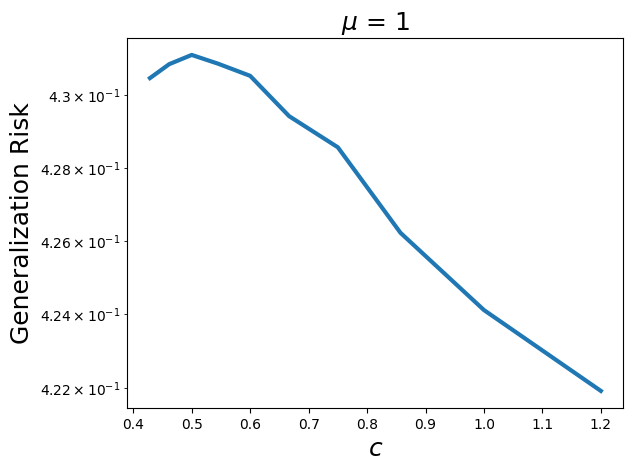

In [ ]:
plt.plot(300/torch.tensor(Ns).cpu(), loss.cpu(), linewidth = 3)
# plt.plot(300/torch.tensor(Ns).cpu(), loss_2.cpu(), linewidth = 3)
plt.yscale("log")
plt.xlabel(r"$c$", fontsize = 18)
plt.ylabel("Generalization Risk", fontsize = 18)
plt.title(r"$\mu$ = 1", fontsize = 18)
plt.savefig("rotated-V.pdf", bbox_inches='tight', facecolor='white', dpi = 100, format = 'pdf')

In [ ]:
plt.plot(torch.tensor(Ns)/500, loss_2, linewidth = 3)
plt.yscale("log")
plt.xlabel(r"$\frac{1}{c}$", fontsize = 18)
plt.ylabel("Generalization Risk", fontsize = 18)
plt.title(r"$\mu$ = 2", fontsize = 18)
plt.savefig("Eigenvalue-shift-mu-2.pdf", bbox_inches='tight', facecolor='white', dpi = 100, format = 'pdf')